In [1]:
# !pip install gymnasium

GIF saved as frozenlake.gif


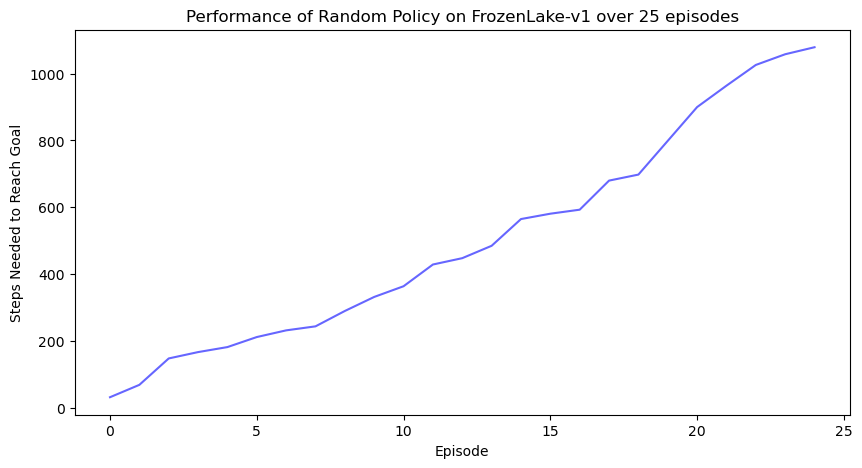

In [1]:
import gymnasium as gym
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import imageio
import matplotlib.pyplot as plt
import re

desc=["SFFF", "FFFF", "FFFF", "FFFG"]
# Initialize the FrozenLake environment
env = gym.make('FrozenLake-v1', desc=desc, is_slippery=False, render_mode='rgb_array')

def render_to_image(env):
    """Convert the text-based rendering to an image."""
    img = env.render()
    return img

def evaluate_and_save_gif(num_episodes=25, filename="frozenlake.gif"):
    """
    Evaluate a random policy, save the rendered outputs to a GIF, and return aggregated rewards.
    """
    frames = []
    rewards = []
    stepCount=[]

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        done = False

        # Add initial state to frames
        frames.append(render_to_image(env))
        count=0
        while not done:
            # Choose a random action
            action = env.action_space.sample()

            # Take a step in the environment
            next_state, reward, done, _, info = env.step(action)
            episode_reward += reward

            # Add the new state to frames
            frames.append(render_to_image(env))
            count+=1
            if count>100:
                done = True
                episode_reward-=1
        rewards.append(episode_reward)
        stepCount.append(count)

    # Save frames as a gif
    imageio.mimsave(filename, [np.array(f) for f in frames], duration=0.5)
    print(f"GIF saved as {filename}")

    return rewards, stepCount

# Evaluate the random policy, save the GIF, and retrieve rewards
num_episodes = 25
rewards, steps = evaluate_and_save_gif(num_episodes=num_episodes, filename="frozenlake.gif")

# Calculate cumulative rewards
cumulative_steps = np.cumsum(steps)

# Plotting the aggregated rewards
plt.figure(figsize=(10, 5))
plt.plot(np.arange(num_episodes),cumulative_steps , alpha=0.6, color='blue')
plt.xlabel('Episode')
plt.ylabel('Steps Needed to Reach Goal')
plt.title('Performance of Random Policy on FrozenLake-v1 over {} episodes'.format(num_episodes))
plt.show()


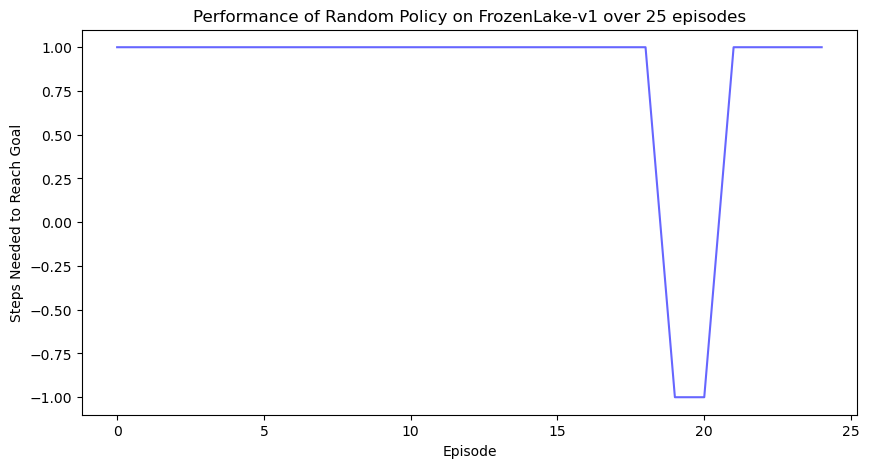

In [2]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(num_episodes),rewards , alpha=0.6, color='blue')
plt.xlabel('Episode')
plt.ylabel('Steps Needed to Reach Goal')
plt.title('Performance of Random Policy on FrozenLake-v1 over {} episodes'.format(num_episodes))
plt.show()

In [3]:
import os
import openai

openai.api_base = "http://localhost:1234/v1"
openai.api_key = ""

In [4]:
goal_state = (3,3)
global system_prompt
global user_prompt
system_prompt = "I am a navigator bot provide context of how you want to control navigation. I output directions, Top, Bottom, Right and Left"

In [ ]:
global history
history = []

desc=["SFFF", "FFFF", "FFFF", "FFFG"]
# Initialize the FrozenLake environment
env = gym.make('FrozenLake-v1', desc=desc, is_slippery=False, render_mode='rgb_array')

def state_to_coordinate(state, nrows=4):
    """
    Convert a state represented by an integer into coordinates (row, column),
    for a coordinate system where the origin is (1,1).

    Parameters:
    state (int): The state integer.
    nrows (int): The number of rows in the grid.

    Returns:
    tuple: A tuple representing the coordinates (row, column), adjusted for the new origin.
    """
    row = state // nrows
    col = state % nrows
    return (col + 1, row + 1)

def env_to_eng(x):
    return state_to_coordinate(x)


def render_to_image(env):
    """Convert the text-based rendering to an image."""
    img = env.render()
    return img

def extract_decision_llama2(text):
    right_search = re.search(r"\bRight\b", text)
    left_search = re.search(r"\bLeft\b", text)
    up_search = re.search(r"\bUp\b", text)
    down_search = re.search(r"\bDown\b", text)
    
    if right_search:
        return 2
    elif left_search:
        return 0
    elif up_search:
        return 1
    elif down_search:
        return 3
    else:
        return 0

def action_generator(hist,env_state,flag=False):
    x = env_to_eng(env_state)
    print(f'Input:{x}')    
    user_message = {"role":"user","content":f"Your current position: {x}, you have to reach (4,4). Answer which direction you move in. Options A) Up B) Down C) Left D) Right"}
    # hist.append(user_message)
    completion = openai.ChatCompletion.create(
    model="local-model", 
    messages=[user_message]
    )
    response = completion.choices[0].message['content']
    print(response)
    # post process action here
    # hist.append({"role":"system","content":response})
    
    action = extract_decision_llama2(response)
    
    #print(f'\nReasoning:{response}')
    return action

def evaluate_llm_and_save_gif(num_episodes=100, filename="frozenlake.gif"):
    """
    Evaluate a random policy, save the rendered outputs to a GIF, and return aggregated rewards.
    """
    frames = []
    rewards = []
    stepCount = []

    for episode in range(num_episodes):
        state = env.reset()[0]
        print("state:" + str(state))
        print("coordinate:" + str(env_to_eng(state)))
        episode_reward = 0
        done = False
        

        # Add initial state to frames
        frames.append(render_to_image(env))
        count=0
        while not done:
            # Choose a random action
            print(state)
            global history
            action = action_generator(history,state,True)

            # Take a step in the environment
            state, reward, done, _, info = env.step(action)
            print("state:" + str(state))
            print("coordinate:" + str(env_to_eng(state)))  
            episode_reward += reward
                  

            # Add the new state to frames
            frames.append(render_to_image(env))
            count+=1
            if count>50:
                done = True
                  
        rewards.append(episode_reward)
        stepCount.append(count)
        history = []

    # Save frames as a gif
    imageio.mimsave(filename, [np.array(f) for f in frames], duration=0.5)
    print(f"GIF saved as {filename}")

    return rewards, steps

# Evaluate the random policy, save the GIF, and retrieve rewards
num_episodes = 5
rewards, steps = evaluate_llm_and_save_gif(num_episodes=num_episodes, filename="frozenlakellm.gif")

# Calculate cumulative rewards
cumulative_steps = np.cumsum(steps)

# Plotting the aggregated rewards
plt.figure(figsize=(10, 5))
plt.plot(np.arange(num_episodes),cumulative_steps , alpha=0.6, color='blue')
plt.xlabel('Episode')
plt.ylabel('Steps Needed to Reach Goal')
plt.title('Performance of Random Policy on FrozenLake-v1 over {} episodes'.format(num_episodes))
plt.show()


state:0
coordinate:(1, 1)
0
Input:(1, 1)
 To reach the destination (4,4) from your current position (1,1), you need to move in a combination of both up and left. Therefore, the correct answer is C) Left, followed by B) Down.
state:0
coordinate:(1, 1)
0
Input:(1, 1)
 To reach the target position at (4, 4) from your current position at (1, 1), you will need to move in a diagonal direction from left to right and upwards. Therefore, the correct option is:

D) Right
state:1
coordinate:(2, 1)
1
Input:(2, 1)
 To move from the point (2, 1) to the point (4, 4), you would need to move in a diagonal direction from the top-left corner to the bottom-right corner of the coordinate plane. Therefore, the correct answer is D) Right.
state:2
coordinate:(3, 1)
2
Input:(3, 1)
 To determine which direction you should move next to reach the target of (4, 4) from your current position of (3, 1), we need to calculate the difference between the x-coordinates and y-coordinates of the two points.

The target poi

In [ ]:
state_to_coordinate(15)

In [ ]:
env.reset()

In [ ]:
env.step(1)

In [ ]:
state_to_coordinate(5)

In [ ]:
def state_to_coordinate(state, nrows=4):
    """
    Convert a state represented by an integer into coordinates (row, column),
    for a coordinate system where the origin is (1,1).

    Parameters:
    state (int): The state integer.
    nrows (int): The number of rows in the grid.

    Returns:
    tuple: A tuple representing the coordinates (row, column), adjusted for the new origin.
    """
    row = state // nrows
    col = state % nrows
    return (col + 1, row + 1)

# Example usage:
state = 15
nrows = 4
coordinates = state_to_coordinate(state, nrows)
print(f"The coordinates for state {state} on a {nrows}x{nrows} grid are: {coordinates}")
